In [1]:
from keras import backend as K

Using TensorFlow backend.


In [2]:
import utils
import numpy as np
import matlab
import matplotlib.pyplot as plt
plt.switch_backend('agg')

In [3]:
import keras.backend.tensorflow_backend as KTF
KTF.set_session(utils.get_session())

In [4]:
from keras.datasets import cifar10
(x_train, _), (x_test, _) = cifar10.load_data()

In [5]:
x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))  # adapt this if using `channels_first` image data format

In [7]:
# Adding AWGN
x_train, x_train_noisy = utils.cifar10_awgn(x_train)
x_test, x_test_noisy = utils.cifar10_awgn(x_test)

5000/50000 images done!
10000/50000 images done!
15000/50000 images done!
20000/50000 images done!
25000/50000 images done!
30000/50000 images done!
35000/50000 images done!
40000/50000 images done!
45000/50000 images done!
50000/50000 images done!
Adding AWGN done!
5000/10000 images done!
10000/10000 images done!
Adding AWGN done!


In [8]:
x_train.shape, x_train_noisy.shape, x_test.shape, x_test_noisy.shape

((250000, 32, 32, 3),
 (250000, 32, 32, 3),
 (50000, 32, 32, 3),
 (50000, 32, 32, 3))

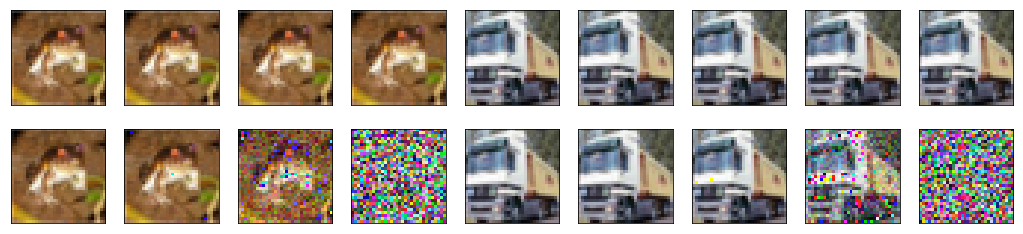

In [9]:
# Displaying noisy images
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_train_noisy[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [2]:
import keras
from keras import losses
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate

inp = Input(shape=(32, 32, 3))    # Input image
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inp)
print x.shape
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

h = MaxPooling2D((2, 2), padding='same')(x) # at this point the representation is (8, 8, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(h)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

recon = Conv2D(3, (3, 3), activation='relu', padding='same')(x)

autoencoder = Model(inputs=[inp], outputs=[recon])
autoencoder.compile(optimizer='adadelta', loss=['mean_squared_error'])

(?, 32, 32, 32)


Fontconfig warning: ignoring UTF-8: not a valid region tag



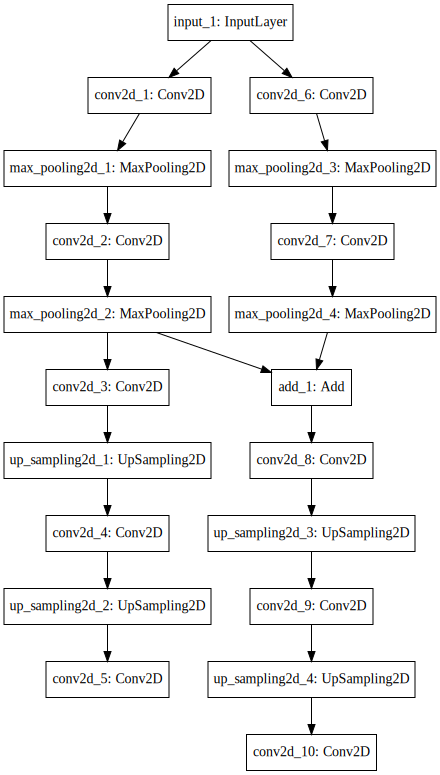

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

In [7]:
################## Model Flow Diagram ####################
from keras.utils import plot_model
plot_model(autoencoder, to_file='my_models/cdA_awgn_model.png')

Fontconfig warning: ignoring UTF-8: not a valid region tag



In [ ]:
from keras.callbacks import TensorBoard
import sys

autoencoder.fit([x_train_noisy],
                [x_train],
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=([x_test_noisy], [x_test, x_test_noisy]),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder', histogram_freq=0, write_graph=False)])

from keras.models import load_model
autoencoder.save('my_models/cdA_awgn.h5')

In [ ]:
decoded_imgs = autoencoder.predict([x_test_noisy])

n = 20
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(4, n, i)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display distorted
    ax = plt.subplot(4, n, i + n)
    plt.imshow(x_test_noisy[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original image reconstruction
    ax = plt.subplot(4, n, i + 2*n)
    plt.imshow(decoded_imgs[0][i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display distorted image reconstruction
    ax = plt.subplot(4, n, i + 3*n)
    plt.imshow(decoded_imgs[1][i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
from keras.models import load_model
autoencoder = load_model('my_models/cdA_awgn.h5')

In [ ]:
filt = autoencoder.predict([x_test_noisy])
vis_filt = utils.visualize(filt, [32, 32], [1, 1], [5, 5], color=1)
vis_dist = utils.visualize(x_test_noisy, [32, 32], [1, 1], [5, 5], color=1)

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(vis_dist)
plt.subplot(1,2,2)
plt.imshow(vis_filt)
plt.show()